TP2: Visión por computadora I (22Co2025)

Integrantes:

    Barniquez Piñero, Alexis Geraldine
    Paniagua, Daniel Gerardo
    Salamone Castro, Brian Adriano


# Enunciado

**Objetivo:** Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:

- Medición sobre todo el frame.

- Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5  o 10% del area total del frame.

**Opcional:**

- Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure
operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.

# Resolución

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Definición de funciones

### Métrica Ejercicio 1

A continuación, se implementa el código para una función que devuelve el valor de la métrica propuesta en el paper *"Image
Sharpness Measure for Blurred Images in Frequency Domain"*. La llamaremos FM.

In [2]:
def fm_metric(gray_image):
    """
    Calcula la métrica de enfoque FM propuesta en el paper 'Image Sharpness Measure for Blurred Images in Frequency Domain'.
    Parámetro:
        gray_image: np.ndarray, imagen en escala de grises (uint8 o float)
    Retorna:
        fm: float, valor de la métrica de enfoque
    """
    # Paso 1: Transformada de Fourier
    F = np.fft.fft2(gray_image)
    # Paso 2: Centrar la frecuencia
    Fc = np.fft.fftshift(F)
    # Paso 3: Valor absoluto
    AF = np.abs(Fc)
    # Paso 4: Máximo valor
    M = np.max(AF)
    # Paso 5: Umbral
    thres = M / 1000.0
    # Paso 6: Contar píxeles mayores al umbral
    count = np.sum(AF > thres)
    # Paso 7: Métrica final
    fm = count / gray_image.size

    return fm


### Métrica Ejercicio 2

A continuación, se define una función para el cálculo de la métrica seleccionada del paper *"Analysis of focus measure
operators in shapefrom focus"*, es la *Modified Laplacian (LAP2)*.

In [3]:
def lap2_metric(gray_image):
    """
    Calcula la métrica de enfoque Modified Laplacian (LAP2) recomendada en el apéndice del paper 'Analysis of focus measure
operators in shapefrom focus'.
    Parámetro:
        gray_image: np.ndarray, imagen en escala de grises
    Retorna:
        lap2: float, valor de la métrica de enfoque
    """
    # Definir los kernels
    Lx = np.array([1, -2, 1], dtype=np.float32).reshape(1, 3)
    Ly = Lx.T
    # Convolución en X y Y
    lap_x = cv2.filter2D(gray_image.astype(np.float32), -1, Lx)
    lap_y = cv2.filter2D(gray_image.astype(np.float32), -1, Ly)
    # Laplaciano modificado
    DmI = np.abs(lap_x) + np.abs(lap_y)
    # Métrica: suma total
    lap2 = np.sum(DmI)
    return lap2


### Detectar segmento con mejor foco

La siguiente función, encuentra el segmento de frames consecutivos con mejor foco a partir de un array de valores de métricas de enfoque. Utiliza una ventana móvil de un tamaño de frames configurable (por defecto en 7) y se queda con la que tenga el valor medio más alto de la métrica de enfoque. Además, exige que todos los frames de la ventana estén por encima de un determinado percentil (por defecto percentil 80).

In [4]:
def find_best_focus_segment(metric_values, window_size=7, min_percentile=0.8):
    """
    Encuentra el segmento de frames consecutivos con mejor enfoque usando una ventana deslizante.
    Solo considera ventanas donde todos los valores están por encima del percentil dado.
    Retorna: (start_idx, end_idx, promedio_segmento)
    """
    metric_values = np.array(metric_values)
    threshold = np.percentile(metric_values, min_percentile * 100)
    best_avg = -np.inf
    best_start = None

    for i in range(len(metric_values) - window_size + 1):
        window = metric_values[i:i+window_size]
        if np.all(window >= threshold):
            avg = np.mean(window)
            if avg > best_avg:
                best_avg = avg
                best_start = i

    if best_start is not None:
        return best_start, best_start + window_size - 1, best_avg
    else:
        return None, None, None  # Ningún segmento cumple el criterio

### Obtener ROI centrada

La función que se define a continuación, devuelve una ROI centrada de la imagen que se le pase como parámetro. El área de la ROI es configurable (por defecto en 10%).

In [5]:
def get_center_roi(gray_image, roi_percent=0.10):
    """
    Extrae una ROI central de la imagen, con área igual a roi_percent del área total.
    """
    h, w = gray_image.shape
    roi_area = int(h * w * roi_percent)
    roi_side = int(np.sqrt(roi_area))
    roi_h = roi_side
    roi_w = roi_side
    # Asegurarse de que la ROI no exceda los límites
    roi_h = min(roi_h, h)
    roi_w = min(roi_w, w)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    return gray_image[start_y:start_y+roi_h, start_x:start_x+roi_w]

## Medición sobre todo el frame

### Curvas de evolución de las métricas

A continuación, se realizan las mediciones de enfoque sobre el todo el frame, para todos los frames del video.
Para mayor eficiencia del código, se calculan las dos métricas requeridas: FM (para el ejercicio 1) y LAP2 (para el ejercicio 2). Ambas se presentan en la misma gráfica. Se utiliza el eje *Y* de la izquierda para FM y el eje *Y* derecho para LAP2, debido a que ambas tienen escalas muy distintas. De esta forma es posible compararlas apropiadamente.

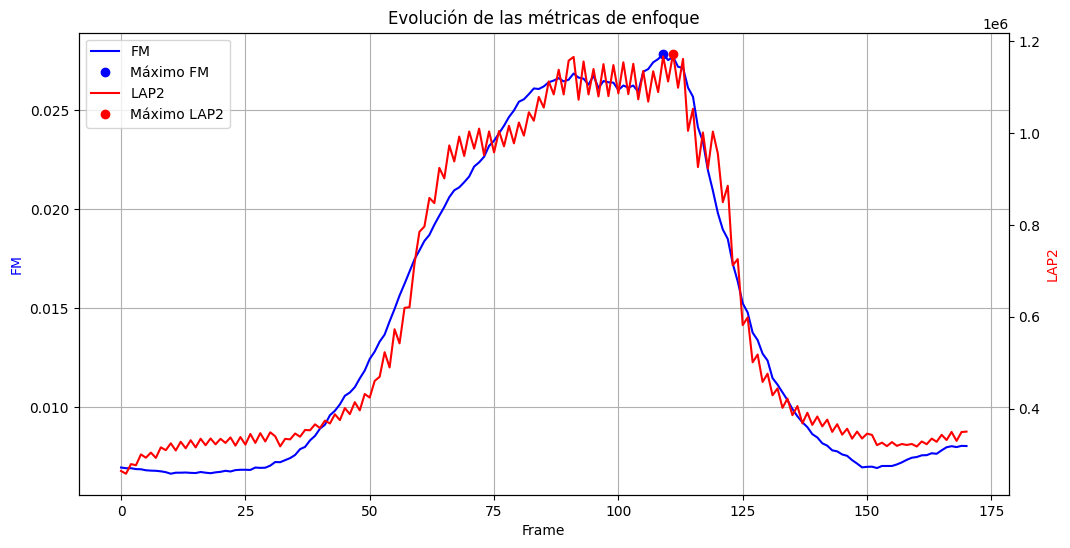

In [7]:
video_path = 'focus_video.mov' 
cap = cv2.VideoCapture(video_path)

fm_metrics = []
lap2_metrics = []
frame_indices = []

if not cap.isOpened():
    print("Error al abrir el archivo de video")
else:
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm = fm_metric(gray)
        lap2 = lap2_metric(gray)
        fm_metrics.append(fm)
        lap2_metrics.append(lap2)
        frame_indices.append(i)
    cap.release()

    # Detectar máximos
    max_fm_idx = int(np.argmax(fm_metrics))
    max_lap2_idx = int(np.argmax(lap2_metrics))

    # Graficar evolución de ambas métricas con dos ejes Y
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()

    ax1.plot(frame_indices, fm_metrics, 'b-', label='FM')
    ax2.plot(frame_indices, lap2_metrics, 'r-', label='LAP2')

    # Marcar máximos en cada curva
    ax1.plot(max_fm_idx, fm_metrics[max_fm_idx], 'bo', label='Máximo FM')
    ax2.plot(max_lap2_idx, lap2_metrics[max_lap2_idx], 'ro', label='Máximo LAP2')

    ax1.set_xlabel('Frame')
    ax1.set_ylabel('FM', color='b')
    ax2.set_ylabel('LAP2', color='r')
    plt.title('Evolución de las métricas de enfoque')

    # Leyendas individuales para cada eje
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    ax1.grid(True)
    plt.show()


### Detección de segmento de máximo enfoque

A continuación, se aplica la función definida anteriormente para detectar la ventana de frames consecutivos con mejor enfoque. Se aplica a ambas métricas para comparar resultados.

In [8]:
window_size = 7
min_percentile = 0.8

seg_freq = find_best_focus_segment(fm_metrics, window_size, min_percentile)
seg_lap = find_best_focus_segment(lap2_metrics, window_size, min_percentile)

if seg_freq[0] is not None:
    print(f"Segmento óptimo FM Frecuencia: frames {seg_freq[0]} a {seg_freq[1]}, promedio: {seg_freq[2]:.4f}")
else:
    print("No se encontró segmento óptimo para FM Frecuencia con los criterios dados.")

if seg_lap[0] is not None:
    print(f"Segmento óptimo FM Laplacian: frames {seg_lap[0]} a {seg_lap[1]}, promedio: {seg_lap[2]:.4f}")
else:
    print("No se encontró segmento óptimo para FM Laplacian con los criterios dados.")


Segmento óptimo FM Frecuencia: frames 107 a 113, promedio: 0.0275
Segmento óptimo FM Laplacian: frames 107 a 113, promedio: 1133931.7500


Como puede verse, con ambas métricas se obtiene el mismo resultado.

## Medición sobre ROI

A continuación, se realizan los mismos procedimientos que se aplicaron a todo el frame, pero en este caso para una ROI.

### Curvas de evolución de las métricas sobre ROI

Al igual que en el caso anterior, se grafican ambas métricas juntas con fines comparativos.

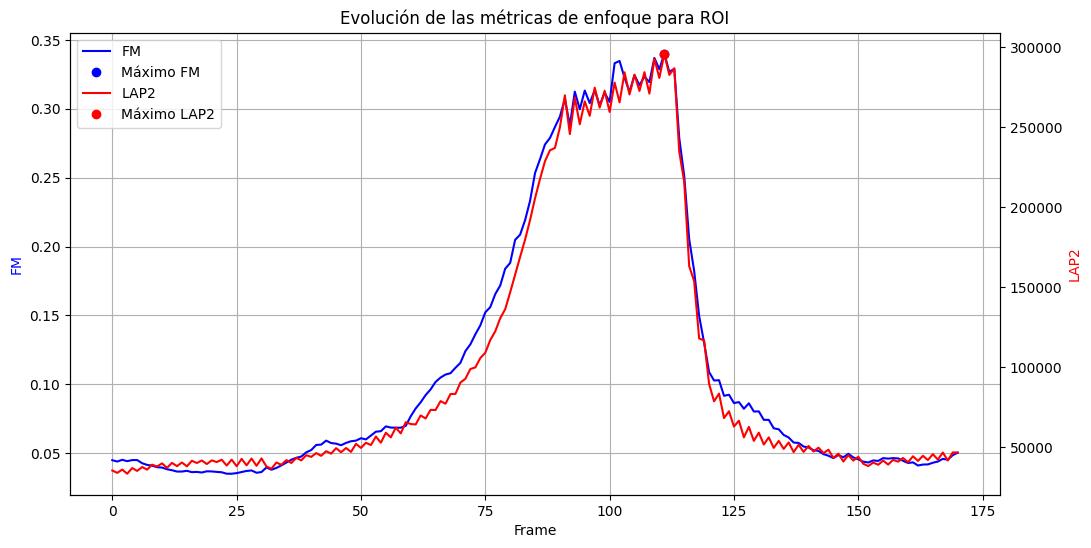

In [9]:
video_path = 'focus_video.mov'
roi_percent = 0.10  # Este valor se puede modificar y usar otro porcentaje
cap = cv2.VideoCapture(video_path)

fm_metrics_roi = []
lap2_metrics_roi = []
frame_indices = []

if not cap.isOpened():
    print("Error al abrir el archivo de video")
else:
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        roi = get_center_roi(gray, roi_percent)
        fm = fm_metric(roi)
        lap2 = lap2_metric(roi)
        fm_metrics_roi.append(fm)
        lap2_metrics_roi.append(lap2)
        frame_indices.append(i)
    cap.release()

    # Detectar máximos
    max_fm_idx_roi = int(np.argmax(fm_metrics_roi))
    max_lap2_idx_roi = int(np.argmax(lap2_metrics_roi))

    # Graficar evolución de ambas métricas con dos ejes Y
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()

    ax1.plot(frame_indices, fm_metrics_roi, 'b-', label='FM')
    ax2.plot(frame_indices, lap2_metrics_roi, 'r-', label='LAP2')

    # Marcar máximos en cada curva
    ax1.plot(max_fm_idx_roi, fm_metrics_roi[max_fm_idx_roi], 'bo', label='Máximo FM')
    ax2.plot(max_lap2_idx_roi, lap2_metrics_roi[max_lap2_idx_roi], 'ro', label='Máximo LAP2')

    ax1.set_xlabel('Frame')
    ax1.set_ylabel('FM', color='b')
    ax2.set_ylabel('LAP2', color='r')
    plt.title('Evolución de las métricas de enfoque para ROI')

    # Leyendas individuales para cada eje
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    ax1.grid(True)
    plt.show()


### Detección de segmento de máximo enfoque para ROI

In [10]:
window_size = 7
min_percentile = 0.8

seg_freq_roi = find_best_focus_segment(fm_metrics_roi, window_size, min_percentile)
seg_lap_roi = find_best_focus_segment(lap2_metrics_roi, window_size, min_percentile)

if seg_freq_roi[0] is not None:
    print(f"Segmento óptimo FM Frecuencia (ROI): frames {seg_freq_roi[0]} a {seg_freq_roi[1]}, promedio: {seg_freq_roi[2]:.4f}")
else:
    print("No se encontró segmento óptimo para FM Frecuencia (ROI) con los criterios dados.")

if seg_lap_roi[0] is not None:
    print(f"Segmento óptimo FM Laplacian (ROI): frames {seg_lap_roi[0]} a {seg_lap_roi[1]}, promedio: {seg_lap_roi[2]:.4f}")
else:
    print("No se encontró segmento óptimo para FM Laplacian (ROI) con los criterios dados.")

Segmento óptimo FM Frecuencia (ROI): frames 107 a 113, promedio: 0.3292
Segmento óptimo FM Laplacian (ROI): frames 107 a 113, promedio: 285015.2812
